# Exercise 4.3: Forming an unfocused beam

In [2]:
## IMPORTS
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
import numpy as np

from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.utils.signals import tone_burst
from kwave.kWaveSimulation import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.colormap import get_color_map

In [20]:
## SIMULATION SETUP
c0 = 1540                       # [m/s] Speed of sound
rho0 = 1000                     # [kg/m^3] Density of water
source_f0 = 1e6                 # [Hz] Source frequency
source_amp = 1e6                # [Pa] Source amplitude
source_cycles = 5              # Number of cycles in the pulse
source_aperture = 1e-2         # [m] Source aperture size

grid_size_x = 100e-3             # [m] Grid size in x (NB: Depth in k-Wave)
grid_size_y = 40e-3             # [m] Grid size in z (NB: Width in k-Wave)
ppw = 5                         # Points per wavelength
cfl = 0.3                       # Related to the time resolution, lower is more accurate (no need to change)

viz_t = grid_size_y / 2 / c0 * 0.75      # Visualization time [s]


In [21]:
## SETUP AND RUN SIMULATION

# Setup Grid
dx = c0 / (ppw * source_f0)     # Grid resolution
Nx = round(grid_size_x / dx)    # Number of grid points in x, NB: This is depth
Ny = round(grid_size_y / dx)    # Number of grid points in y, NB: This is width (lateral)
kgrid = kWaveGrid([Nx, Ny], [dx, dx])
kgrid.makeTime(c0, cfl)         # Make time array based on the Courant-Friedrichs-Lewy (CFL) condition

# Setup source
# Source signal, Gaussian pulse
source_sig = source_amp * tone_burst(1 / kgrid.dt, source_f0, source_cycles)

# Define kWave source object
source = kSource()
source.p_mask = np.zeros_like(kgrid.x)

# Form line source
Naperture = round(source_aperture / dx)
source_radius = Naperture // 2
pos = [10, Ny // 2]
source_mask = range(pos[1] - source_radius, pos[1] + source_radius, 1)

source.p_mask[pos[0], source_mask] = 1

source.p = source_sig                                       # Source signal (pressure source)

# Setup sensor
sensor = kSensor(record=['p', 'p_max'])                     # Sensor object, record pressure and maximum pressure
sensor.mask = np.ones_like(kgrid.x)                         # Sensor mask, all grid points

# Setup medium
medium = kWaveMedium(sound_speed=c0, density=rho0)          # Define medium object, simple homogeneous medium
medium.sound_speed = np.ones_like(kgrid.x) * c0

# Setup simulation options
simulation_options = SimulationOptions(
    pml_auto=True,
    pml_inside=False,
    save_to_disk=True,
    data_cast='single',
)
execution_options = SimulationExecutionOptions(is_gpu_simulation=False)

# Run 2D simulation (to save some time)
sensor_data = kspaceFirstOrder2D(kgrid=kgrid, medium=medium, source=source, sensor=sensor,
                                  simulation_options=simulation_options, execution_options=execution_options)

# Extract pressure field from
p_field = np.reshape(sensor_data["p"], (kgrid.Nt, Nx, Ny), order="F")   # Stored in Fortran ordering for some reason

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                     16 │
│ Processor name: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                                  375 x 162 │
│ Medium type:                                               2D │
│ Simulation time steps:                                   1167 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory a

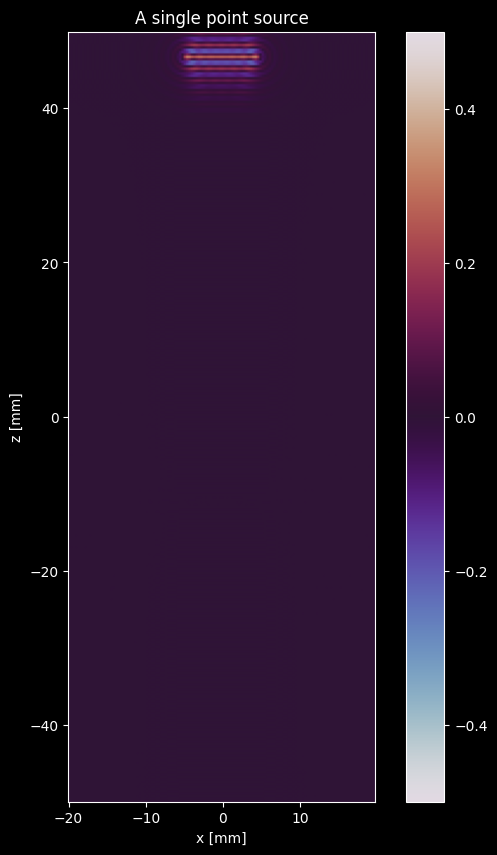

In [10]:
## VISUALIZATION
plt.style.use('dark_background')

# Get frame number to plot
viz_t = grid_size_y / 2 / c0 * 0.4      # Visualization time [s]
N_frame = np.round(np.where(kgrid.t_array[0] > viz_t)[0][0]).astype(int)   # Number of frames to visualize

# Normalize frames based on the maximum value over all frames
max_value = np.max(np.abs(p_field))
p_plot = p_field / max_value

cmap = 'twilight'
extent = np.array([kgrid.y_vec[0], kgrid.y_vec[-1], kgrid.x_vec[0], kgrid.x_vec[-1]])*1e3

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 10))
image = plt.imshow(p_plot[N_frame], cmap=cmap, vmin=-0.5, vmax=0.5, extent=extent)
plt.colorbar()
plt.xlabel('x [mm]')
plt.ylabel('z [mm]')
plt.title('A single point source')
plt.show()

In [6]:
# Create animation showing propagation over time
def update(frame):
    image.set_data(p_plot[frame])
    ax.set_title(f"Frame: {frame}/{kgrid.Nt}")
    return [image]

ANIM_START = 0
ANIM_END = kgrid.Nt
ANIM_STEP = 10
ANIM_FILENAME = "task3_line_source.mp4"

animation = FuncAnimation(fig, update, frames=np.arange(ANIM_START, ANIM_END, ANIM_STEP), interval=100, blit=True)

from os import makedirs
makedirs(f"../output/4/", exist_ok=True)
animation.save(f"../output/4/{ANIM_FILENAME}", writer='ffmpeg', fps=30)


## Observations

When we first see the pulse appear it has the approximate size and shape of our transducer before propagating outwards.
Because it's linear, much like in the previous task we see the wave interfering with itself and quickly most of the pressure waves going off to the sides are eliminated.
Since the line source is placed rather close to the top, the parts of the sound moving upwards quickly dissappears off screen.

As time passes, the wave moves downward with traces going up against the sides. Towards the end of the simulation, the wave has propagated all the way down and for the most part only the section of the sound moving downwards remain.

Text(0, 0.5, 'Width [mm]')

<Figure size 2000x800 with 0 Axes>

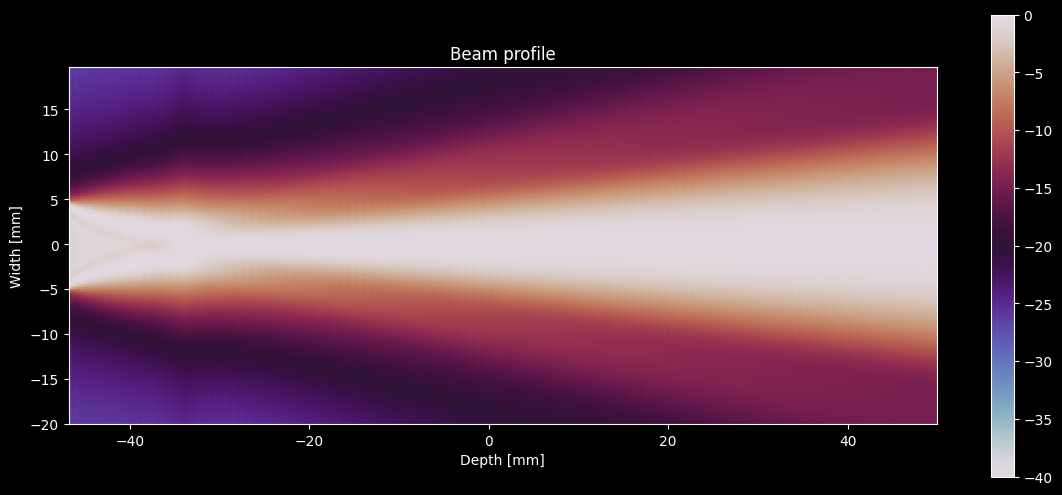

In [22]:
# Vizualize beam profile

offset = pos[0]

extent = np.array([kgrid.x_vec[offset], kgrid.x_vec[-1], kgrid.y_vec[0], kgrid.y_vec[-1]])*1e3

p_max = sensor_data["p_max"]
p_max = np.reshape(p_max, (Nx, Ny), order="F")

# dB conversion and normalization
p_max_log = 20 * np.log10(p_max)
p_max_log_normal = p_max_log - np.max(p_max_log)

# Normalize
max_d = np.max(p_max, axis=1)
p_max_normal = p_max / max_d[:, None]
p_max_normal_db = 20 * np.log10(p_max_normal)

# Find transition zone
transition_start = source_aperture**2/(np.pi*c0/source_f0)
ap_start = kgrid.x_vec[offset]
transition_end = ap_start + transition_start


plt.figure(figsize=(20, 8))

fig, axes = plt.subplots(1, 2, figsize=(14,6))
plt.clf()
plt.imshow(p_max_normal_db[offset::,:].T, cmap="twilight", extent=extent, vmin=-40, vmax=0)
plt.colorbar()
plt.title("Beam profile")
plt.xlabel("Depth [mm]")
plt.ylabel("Width [mm]")

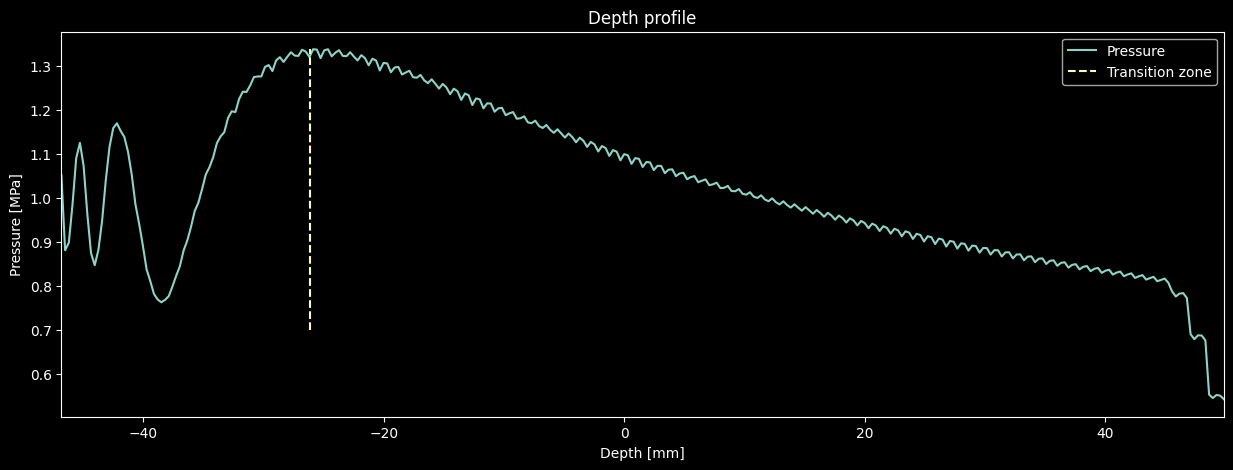

In [16]:
# Vizualize depth profile

plt.figure(figsize=(15, 5))
plt.plot(kgrid.x_vec[offset::]*1e3, p_max[offset::, round(Ny/2)]/1e6)
plt.plot([transition_end*1e3, transition_end*1e3], [0.7, np.max(p_max)/1e6], '--')
plt.title("Depth profile")
plt.xlabel("Depth [mm]")
plt.ylabel("Pressure [MPa]")
plt.xlim([kgrid.x_vec[offset]*1e3, kgrid.x_vec[-1]*1e3])
plt.legend(["Pressure", "Transition zone"]);


## More Observations

b) The beam profile does indeed resemble the theoretical unfocused beam profile shape.
    Initially we see the field closely resembling the shape of the transducer, this is followed by diffraction focus (seen when the wave interferes initially and most of the sideways components dissipate/destruct. The wave is forming into a beam.) of the wave and finally the wave diverges as it gets further away from the transducer.

c) We can calculate the position of the maximum pressure like this: `L^2(pi*lambda) = ((0.1^2)/(3.14159*0.1540)) = 22.67mm`.

d) With the near-continuous wave, we can see the side lobes much more clearly whereas in the inital beam profile we could for the most part only see the main beam.

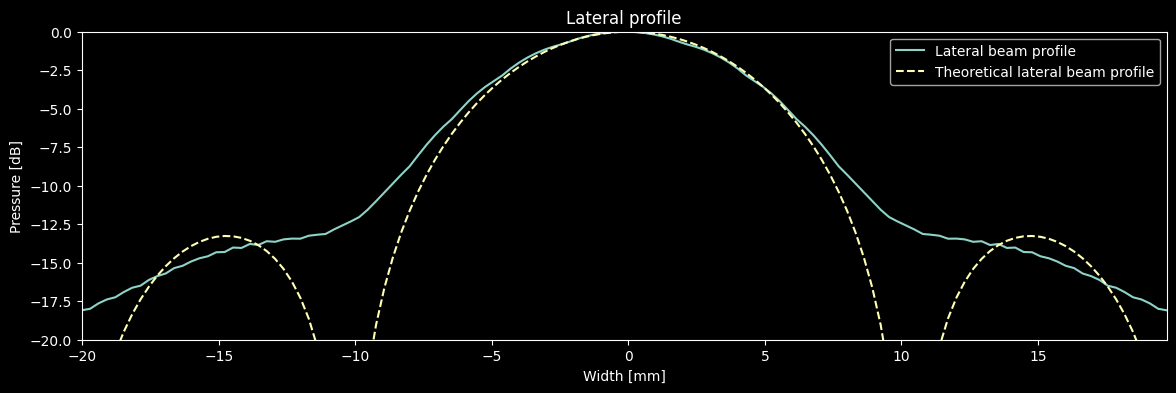

In [24]:
# Vizualising the lateral profile

# Theoretical lateral beam profile
z_BP = 20e-3
a = source_aperture * kgrid.y_vec
b = c0 / source_f0 * (z_BP - ap_start)
t_BP = np.sinc(a / b)
t_BP_dB = 10 * np.log10(t_BP**2)

plt.figure(figsize=(14, 4))
plt.plot(kgrid.y_vec*1e3, p_max_normal_db[np.where(kgrid.x_vec >= z_BP)[0][0], :])
plt.plot(kgrid.y_vec*1e3, t_BP_dB, '--')

plt.title("Lateral profile")
plt.xlabel("Width [mm]")
plt.ylabel("Pressure [dB]")
plt.legend(['Lateral beam profile', 'Theoretical lateral beam profile'])
plt.ylim([-20, 0])
plt.xlim([kgrid.y_vec[0]*1e3, kgrid.y_vec[-1]*1e3]);


f) When plotting the simulated lateral profile together with the theoretical one it seems to match somewhat.
    The main lobe has roughly the same shape and size and the overall shape of the profile is a decent match.
    The side lobes appear to be mostly missing, however. Or rather it seems they are there (albeit barely. If they weren't there at all, the pressure would have dropped off faster around the main lobe), but that they are much less pronounced than expected.